In [ ]:
!nvidia-smi

Mon May 30 15:57:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/vessel_segmentation/

/content/drive/MyDrive/vessel_segmentation


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.0 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')

def jacard(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  y_pred_f = tf.cast(y_pred_f, tf.float32)
  y_true_f = tf.cast(y_true_f, tf.float32)
  intersection = K.sum ( y_true_f * y_pred_f)
  union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
  return intersection/union

def dice_coef(y_true, y_pred):
  smooth = 1.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  y_pred_f = tf.cast(y_pred_f, tf.float32)
  y_true_f = tf.cast(y_true_f, tf.float32)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def log_cosh_dice_loss(y_true, y_pred):
  return tf.math.log(tf.math.cosh(1 - dice_coef(y_true, y_pred)))

## MultiResUNet

```python
def step_decay(epoch):
   initial_lrate = LRATE
   drop = 0.5
   epochs_drop = 10.0 # drop lr by half every 10 epochs
   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

lr_scheduler = LearningRateScheduler(step_decay)
```

- 12 train
- 8 validation

In [ ]:
from model.MultiResUNet import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from generator import *
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)
plot_history = []

IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

EPOCHS = 100
LOSS = 'log_cosh_dice_loss'

train_dataset = './data/artery/train_artery.h5'
valid_dataset = './data/artery/valid_artery.h5'
BATCH_SIZE = 4

train_gen = DatasetGenerator(dataset_path=train_dataset,batch_size=BATCH_SIZE)
TOTAL = train_gen.getNumberOfTotalImages()
train_epoch = train_gen.generator()

valid_gen = DatasetGenerator(dataset_path=valid_dataset,batch_size=BATCH_SIZE)
TOTAL_VAL = valid_gen.getNumberOfTotalImages()
valid_epoch = valid_gen.generator()

steps_per_epoch = int(TOTAL / BATCH_SIZE)

model = MultiResUNet(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

loss_func = log_cosh_dice_loss
    
steps_per_epoch = int(TOTAL / BATCH_SIZE)
cycles_n = 30
step_size = EPOCHS * steps_per_epoch / (cycles_n*2)
LRATE = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
                                            maximal_learning_rate=1e-2,
                                            step_size=step_size,
                                            scale_fn=lambda x: 1.0)

optimizer_func = Adam(learning_rate=LRATE)

model.compile(optimizer=optimizer_func, loss=loss_func, metrics=[dice_coef, jacard, 'accuracy'])

model_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/model_{val_dice_coef:.3f}.h5',
    monitor='val_dice_coef',
    verbose=1,
    save_best_only=True,
    mode='max')

callbacks = [model_checkpoint]

history = model.fit(train_epoch,
          steps_per_epoch=int(TOTAL / BATCH_SIZE),
          verbose=1,
          epochs=EPOCHS,
          shuffle=True,
          validation_data=valid_epoch,
          validation_steps=int(TOTAL_VAL / BATCH_SIZE),
          callbacks=callbacks)

plot_history.append(history.history)

train_gen.close()
valid_gen.close()

The number of total images: 1660
The number of total images: 433
Epoch 1/100
415/415 [==============================] - ETA: 0s - loss: 0.4193 - dice_coef: 0.0192 - jacard: 0.0097 - accuracy: 0.8714
Epoch 1: val_dice_coef improved from -inf to 0.00633, saving model to ./checkpoints/model_0.006.h5
415/415 [==============================] - 286s 631ms/step - loss: 0.4193 - dice_coef: 0.0192 - jacard: 0.0097 - accuracy: 0.8714 - val_loss: 0.4290 - val_dice_coef: 0.0063 - val_jacard: 0.0032 - val_accuracy: 0.0939
Epoch 2/100
415/415 [==============================] - ETA: 0s - loss: 0.1878 - dice_coef: 0.4065 - jacard: 0.2851 - accuracy: 0.9953
Epoch 2: val_dice_coef improved from 0.00633 to 0.61835, saving model to ./checkpoints/model_0.618.h5
415/415 [==============================] - 232s 559ms/step - loss: 0.1878 - dice_coef: 0.4065 - jacard: 0.2851 - accuracy: 0.9953 - val_loss: 0.0746 - val_dice_coef: 0.6183 - val_jacard: 0.4533 - val_accuracy: 0.9987
Epoch 3/100
415/415 [===========

In [ ]:
from model.MultiResUNet import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from generator import *
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from keras.models import load_model

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)
plot_history = []

IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

EPOCHS = 30
LOSS = 'log_cosh_dice_loss'

train_dataset = './data/artery_12_8/train_artery.h5'
valid_dataset = './data/artery_12_8/valid_artery.h5'
BATCH_SIZE = 4

train_gen = DatasetGenerator(dataset_path=train_dataset,batch_size=BATCH_SIZE)
TOTAL = train_gen.getNumberOfTotalImages()
train_epoch = train_gen.generator()

valid_gen = DatasetGenerator(dataset_path=valid_dataset,batch_size=BATCH_SIZE)
TOTAL_VAL = valid_gen.getNumberOfTotalImages()
valid_epoch = valid_gen.generator()

steps_per_epoch = int(TOTAL / BATCH_SIZE)

model = load_model("./checkpoints/model_0.792.h5",compile=False)

loss_func = log_cosh_dice_loss
    
steps_per_epoch = int(TOTAL / BATCH_SIZE)
cycles_n = 30
step_size = EPOCHS * steps_per_epoch / (cycles_n*2)
LRATE = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
                                            maximal_learning_rate=1e-2,
                                            step_size=step_size,
                                            scale_fn=lambda x: 1.0)
MOMENTUM = 0.95

optimizer_func = SGD(learning_rate=LRATE, momentum=MOMENTUM)

model.compile(optimizer=optimizer_func, loss=loss_func, metrics=[dice_coef, jacard, 'accuracy'])

model_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/model_{val_dice_coef:.3f}.h5',
    monitor='val_dice_coef',
    verbose=1,
    save_best_only=True,
    mode='max')

callbacks = [model_checkpoint]

history = model.fit(train_epoch,
          steps_per_epoch=int(TOTAL / BATCH_SIZE),
          verbose=1,
          epochs=EPOCHS,
          shuffle=True,
          validation_data=valid_epoch,
          validation_steps=int(TOTAL_VAL / BATCH_SIZE),
          callbacks=callbacks)

plot_history.append(history.history)

train_gen.close()
valid_gen.close()

The number of total images: 1660
The number of total images: 433
Epoch 1/30
415/415 [==============================] - ETA: 0s - loss: 0.0091 - dice_coef: 0.8721 - jacard: 0.7759 - accuracy: 0.9992
Epoch 1: val_dice_coef improved from -inf to 0.79066, saving model to ./checkpoints/model_0.791.h5
415/415 [==============================] - 250s 592ms/step - loss: 0.0091 - dice_coef: 0.8721 - jacard: 0.7759 - accuracy: 0.9992 - val_loss: 0.0249 - val_dice_coef: 0.7907 - val_jacard: 0.6608 - val_accuracy: 0.9990
Epoch 2/30
415/415 [==============================] - ETA: 0s - loss: 0.0090 - dice_coef: 0.8724 - jacard: 0.7761 - accuracy: 0.9992
Epoch 2: val_dice_coef improved from 0.79066 to 0.79107, saving model to ./checkpoints/model_0.791.h5
415/415 [==============================] - 233s 560ms/step - loss: 0.0090 - dice_coef: 0.8724 - jacard: 0.7761 - accuracy: 0.9992 - val_loss: 0.0251 - val_dice_coef: 0.7911 - val_jacard: 0.6622 - val_accuracy: 0.9990
Epoch 3/30
415/415 [==============

## Visualization

In [ ]:
his = {}

for name in ['loss','val_loss','dice_coef','val_dice_coef','jacard','val_jacard','accuracy','val_accuracy']:
  arr = []
  for plot in plot_history:
    arr += plot[name]
  his[name] = arr

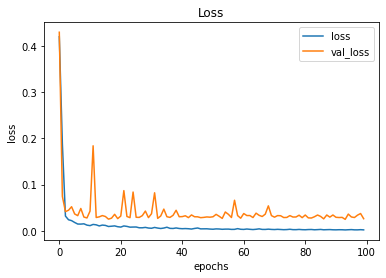

In [ ]:
import matplotlib.pyplot as plt

name = 'loss'

plt.title('Loss')
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

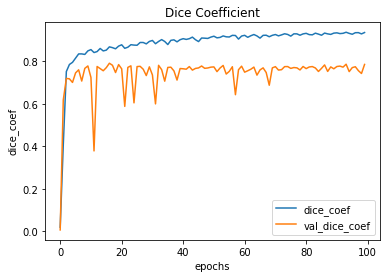

In [ ]:
name = 'dice_coef'

plt.title("Dice Coefficient")
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

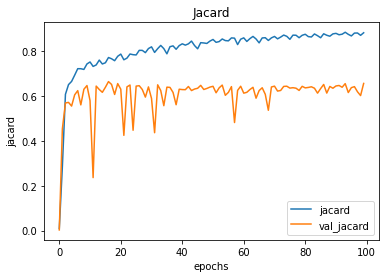

In [ ]:
name = 'jacard'

plt.title("Jacard")
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

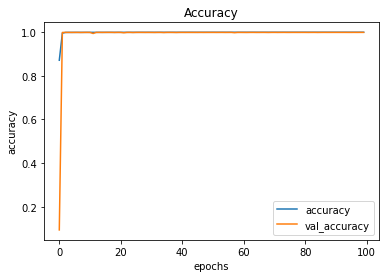

In [ ]:
name = 'accuracy'

plt.title("Accuracy")
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

## Visualization 2

In [ ]:
his = {}

for name in ['loss','val_loss','dice_coef','val_dice_coef','jacard','val_jacard','accuracy','val_accuracy']:
  arr = []
  for plot in plot_history:
    arr += plot[name]
  his[name] = arr

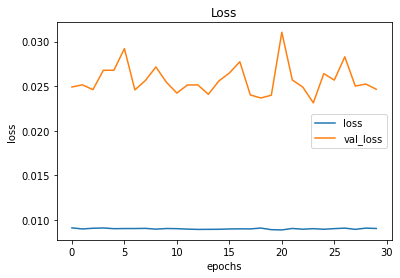

In [ ]:
import matplotlib.pyplot as plt

name = 'loss'

plt.title('Loss')
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

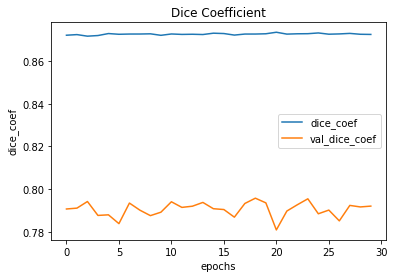

In [ ]:
name = 'dice_coef'

plt.title("Dice Coefficient")
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

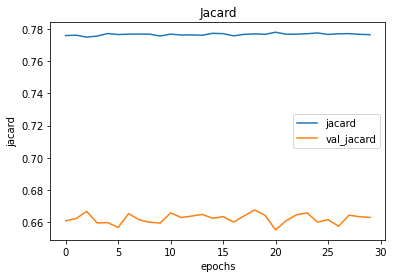

In [ ]:
name = 'jacard'

plt.title("Jacard")
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

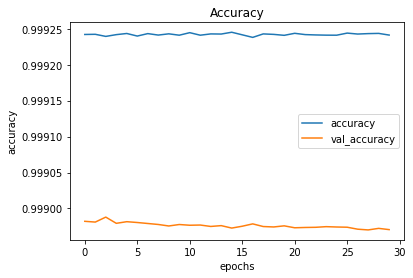

In [ ]:
name = 'accuracy'

plt.title("Accuracy")
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

## Evaluation

In [ ]:
from keras.models import load_model

model = load_model("./checkpoints/model_0.796.h5",compile=False)

In [ ]:
import os
from skimage import io
import numpy as np
from generator import *

test_dataset = './data/artery_12_8/valid_artery.h5'

BATCH_SIZE = 4

print('='*32)
test_gen = DatasetReader(dataset_path=test_dataset,batch_size=BATCH_SIZE)
test_epoch = test_gen.generator()
test_images, test_labels = [], []
for i in range(test_gen.getNumberOfTotalImages()):
  image, label = test_epoch.__next__()
  test_images.append(image)
  test_labels.append(label)
print('='*32)

The number of total images: 433


In [ ]:
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

In [ ]:
test_images.shape

(433, 512, 512, 1)

In [ ]:
output_images = model.predict(test_images, verbose=1)

14/14 [==============================] - 19s 994ms/step


In [ ]:
print('=' * 30)
print('Saving output to files...')
np.save('output.npy', output_images)
print('=' * 30)

Saving output to files...


In [ ]:
dir = 'predictions'
if not os.path.exists(dir):
	os.mkdir(dir)

i = 0
for image in output_images:
	image = (image[:, :, 0] * 255.).astype(np.uint8)
	ground_truth = (test_labels[i,:,:,0] * 255.).astype(np.uint8)
	origin = (test_images[i,:,:,0] *255.).astype(np.uint8)
	io.imsave(os.path.join(dir, str(i) + '_orgin.png'), origin)
	io.imsave(os.path.join(dir, str(i) + '_prediction.png'), image)
	io.imsave(os.path.join(dir, str(i) + '_groundtruth.png'), ground_truth)
	i += 1

print(f"The number of total images in test dataset are: {str(i)}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/0_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/0_groundtruth.png is a low contrast image
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/1_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/1_groundtruth.png is a low contrast image
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/2_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/2_groundtruth.png is a low cont

The number of total images in test dataset are: 433


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/431_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/431_groundtruth.png is a low contrast image
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/432_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/432_groundtruth.png is a low contrast image
  if sys.path[0] == '':
